In [23]:
import numpy as np
from joblib import Parallel, delayed
import gc
import sys
sys.setrecursionlimit(10**6) 
import matplotlib.pyplot as plt
import re
gc.collect()
from time import time
N=28
U0=8./N

In [24]:
from scipy import sparse
def InnerProduct(A,B):
    hashedA = np.array([hash(s) for s in A['keys']])
    hashedB = np.array([hash(s) for s in B['keys']])
    AdjMat=np.equal.outer(hashedB, hashedA)
    SparsedAdjMat=sparse.csr_matrix(AdjMat)
    IP=np.sum(sparse.csr_matrix.dot(sparse.csr_matrix.dot(B['vals'],SparsedAdjMat),A['vals']))
    return IP
#def InnerProd(Psi0Rec,Psi1Rec):
#    InnerProd=0
    #Psi0Rec = np.rec.fromarrays([Psi0[:,0],Psi0[:,1].astype(np.float64)], names='keys,vals')
    #Psi1Rec = np.rec.fromarrays([Psi1[:,0],Psi1[:,1].astype(np.float64)], names='keys,vals')
#    for i in range(len(Psi0Rec)):
#        InnerProd=InnerProd+ np.sum(Psi0Rec['vals'][i]*Psi1Rec['vals'][Psi1Rec['keys']==Psi0Rec['keys'][i]])
#    return InnerProd

In [25]:
def EnergyFlucPairCont(index,pair1,pair2):
    ti=time()
    PsiObj1=PsiObj.copy()
    PsiObj2=PsiObj.copy()
    #generating Reg. Exp. strings for pair1
    BitConfiGij_00=''.join(['0' if((ind==pair1[0]) or (ind==pair1[1])) else '.' for ind in range(N)])
    BitConfiGij_01=''.join(['0' if(ind==pair1[0]) else '1' if(ind==pair1[1]) else '.' for ind in range(N)])
    BitConfiGij_10=''.join(['1' if(ind==pair1[0]) else '0' if(ind==pair1[1]) else '.' for ind in range(N)])
    BitConfiGij_11=''.join(['1' if((ind==pair1[0]) or (ind==pair1[1])) else '.' for ind in range(N)])
    r_00 = re.compile(BitConfiGij_00)
    r_01 = re.compile(BitConfiGij_01)
    r_10 = re.compile(BitConfiGij_10)
    r_11 = re.compile(BitConfiGij_11)
    ti=time()
    PsiSubSetDiff = PsiObj[np.vectorize(lambda x:bool(r_01.match(x) or r_10.match(x)))(PsiObj['keys'])]
    PsiSubSetSame = PsiObj[np.vectorize(lambda x:bool(r_00.match(x) or r_11.match(x)))(PsiObj['keys'])]
    PsiSubSetDiff['keys']=[conf[0:pair1[0]]+conf[pair1[1]]+conf[pair1[0]+1:pair1[1]]+conf[pair1[0]]+conf[pair1[1]+1:N] for conf in PsiSubSetDiff['keys']]
    PsiSubSetDiff['vals']=-(U0/4)*PsiSubSetDiff['vals']
    PsiSubSetSame['vals']=(U0/4)*PsiSubSetSame['vals']
    #configs. generated by pair1 scatterers.
    PsiObj1=np.concatenate([PsiSubSetDiff,PsiSubSetSame])
    if(pair1!=pair2):
        #generating Reg. Exp. strings for pair2
        BitConfiGij_00=''.join(['0' if((ind==pair2[0]) or (ind==pair2[1])) else '.' for ind in range(N)])
        BitConfiGij_01=''.join(['0' if(ind==pair2[0]) else '1' if(ind==pair2[1]) else '.' for ind in range(N)])
        BitConfiGij_10=''.join(['1' if(ind==pair2[0]) else '0' if(ind==pair2[1]) else '.' for ind in range(N)])
        BitConfiGij_11=''.join(['1' if((ind==pair2[0]) or (ind==pair2[1])) else '.' for ind in range(N)])
        r_00 = re.compile(BitConfiGij_00)
        r_01 = re.compile(BitConfiGij_01)
        r_10 = re.compile(BitConfiGij_10)
        r_11 = re.compile(BitConfiGij_11)
        PsiSubSetDiff = PsiObj[np.vectorize(lambda x:bool(r_01.match(x) or r_10.match(x)))(PsiObj['keys'])]
        PsiSubSetSame = PsiObj[np.vectorize(lambda x:bool(r_00.match(x) or r_11.match(x)))(PsiObj['keys'])]
        PsiSubSetDiff['keys']=[conf[0:pair2[0]]+conf[pair2[1]]+conf[pair2[0]+1:pair2[1]]+conf[pair2[0]]+conf[pair2[1]+1:N] for conf in PsiSubSetDiff['keys']]
        PsiSubSetDiff['vals']=-(U0/4)*PsiSubSetDiff['vals']
        PsiSubSetSame['vals']=(U0/4)*PsiSubSetSame['vals']
        #configs. generated by pair2 scatterers.
        PsiObj2=np.concatenate([PsiSubSetDiff,PsiSubSetSame])
        IP1=2*InnerProduct(PsiObj1,PsiObj2)
        if(index in indexes):
            IP2=InnerProduct(PsiObj1,PsiObj)
            IP=[IP1,IP2]
        else:
            IP=[IP1,0]
    else:
        IP1=InnerProduct(PsiObj1,PsiObj1)
        if(index in indexes):
            IP2=InnerProduct(PsiObj1,PsiObj)
            IP=[IP1,IP2]
        else:
            IP=[IP1,0]
    #print("time taken for inner products-",time()-ti)
    #print(index)
    return IP

In [27]:
fileIndex=['0','1','2','3','4']#,'5']
FlucArr1=np.zeros(6)
FlucArr2=np.zeros(6)
count=0
points0=[6,13,20,27]#RG fixed points
pairs0=[[point1,point2] for point1 in points0 for point2 in points0 if point1<point2]
points1=points0+[point-1 for point in points0]#reverse RG step-1
pairs1=[[point1,point2] for point1 in points1 for point2 in points1 if point1<point2]
points2=points1+[point-2 for point in points0]#reverse RG step-2
pairs2=[[point1,point2] for point1 in points2 for point2 in points2 if point1<point2]
points3=points2+[point-3 for point in points0]#reverse RG step-3
pairs3=[[point1,point2] for point1 in points3 for point2 in points3 if point1<point2]
points4=points3+[point-4 for point in points0]#reverse RG step-3
pairs4=[[point1,point2] for point1 in points4 for point2 in points4 if point1<point2]
points5=points4+[point-5 for point in points0]#reverse RG step-3
pairs5=[[point1,point2] for point1 in points5 for point2 in points5 if point1<point2]
points6=points5+[point-6 for point in points0]#reverse RG step-3
pairs6=[[point1,point2] for point1 in points6 for point2 in points6 if point1<point2]
for k in fileIndex:
    pairs=eval('pairs%s'%(k))
    indPairs2Arr =np.array([np.array([i,j]) for i in range(len(pairs)) for j in range(len(pairs)) if i<=j])
    indexes=np.where(np.diff(indPairs2Arr[:,0]) != 0)[0]
    EnergyFlucArr=np.zeros([len(indPairs2Arr),2])
    print("file-",k)
    Psi=open("/home/nivedita/7thMay/Project-EntanglementRG/DataFiles/ManyBodyWavefunctions/manyBodyWaveFunction28#"+k+".txt","+r")
    PsiConf=Psi.readlines()
    Psi.close()
    manyBodyKetGS=np.array([np.array([conf[:N],conf[N:]])for conf in PsiConf[2:]])
    PsiObj=np.rec.fromarrays([manyBodyKetGS[:,0],manyBodyKetGS[:,1].astype(np.float64)], names='keys,vals')
    #for i in range(len(indPairs2Arr)):
    #    print(pairs0[indPairs2Arr[i][0]])
    #    EnergyFlucArr[i]=EnergyFlucPairCont(i,pairs[indPairs2Arr[i][0]],pairs[indPairs2Arr[i][1]]) 
    #EnergyFlucArr=[EnergyFlucPairCont(i,pairs[indPairs2Arr[i][0]],pairs[indPairs2Arr[i][1]]) for i in pbar(range(len(indPairs2Arr)))]
    EnergyFlucArr=Parallel(n_jobs=20,verbose=5)(delayed(EnergyFlucPairCont)(i,pairs[indPairs2Arr[i][0]],pairs[indPairs2Arr[i][1]]) for i in range(len(indPairs2Arr)))
    Efluc=np.asarray(EnergyFlucArr)
    FlucArr1[count]=np.sum(Efluc[:,0])
    FlucArr2[count]=np.sum(Efluc[:,1])
    #print(FlucArr1[count])
    count=count+1

file- 0


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  21 | elapsed:    0.4s remaining:    4.1s
[Parallel(n_jobs=20)]: Done   7 out of  21 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=20)]: Done  12 out of  21 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  17 out of  21 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  21 out of  21 | elapsed:    0.5s finished


file- 1


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done 144 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 406 out of 406 | elapsed:    1.0s finished


file- 2


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 124 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 584 tasks      | elapsed:    1.5s
[Parallel(n_jobs=20)]: Done 1780 tasks      | elapsed:    2.3s
[Parallel(n_jobs=20)]: Done 2172 out of 2211 | elapsed:    2.9s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 2211 out of 2211 | elapsed:    2.9s finished


file- 3


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done 144 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 1108 tasks      | elapsed:    1.2s
[Parallel(n_jobs=20)]: Done 6620 tasks      | elapsed:    2.3s
[Parallel(n_jobs=20)]: Done 7260 out of 7260 | elapsed:    2.8s finished


file- 4


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 122 tasks      | elapsed:    1.2s
[Parallel(n_jobs=20)]: Done 248 tasks      | elapsed:    2.0s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    3.1s
[Parallel(n_jobs=20)]: Done 608 tasks      | elapsed:    4.5s
[Parallel(n_jobs=20)]: Done 842 tasks      | elapsed:    6.3s
[Parallel(n_jobs=20)]: Done 1112 tasks      | elapsed:    8.2s
[Parallel(n_jobs=20)]: Done 1418 tasks      | elapsed:   10.3s
[Parallel(n_jobs=20)]: Done 1760 tasks      | elapsed:   12.5s
[Parallel(n_jobs=20)]: Done 2138 tasks      | elapsed:   15.1s
[Parallel(n_jobs=20)]: Done 2552 tasks      | elapsed:   18.0s
[Parallel(n_jobs=20)]: Done 3002 tasks      | elapsed:   21.1s
[Parallel(n_jobs=20)]: Done 3488 tasks      | elapsed:   24.4s
[Parallel(n_jobs=20)]: Done 4010 tasks      | elapsed:   27.8s
[Parallel(n_jobs=20)]: Done 5332 tasks      | e

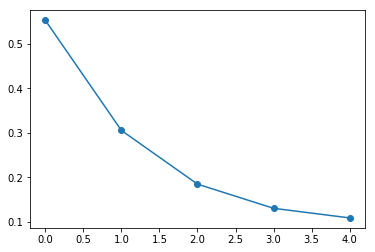

In [34]:
plt.plot(np.sqrt(FlucArr1[:-1]-FlucArr2[:-1]*FlucArr2[:-1])/FlucArr2[:-1],marker='o')

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 <a list of 7 Text yticklabel objects>)

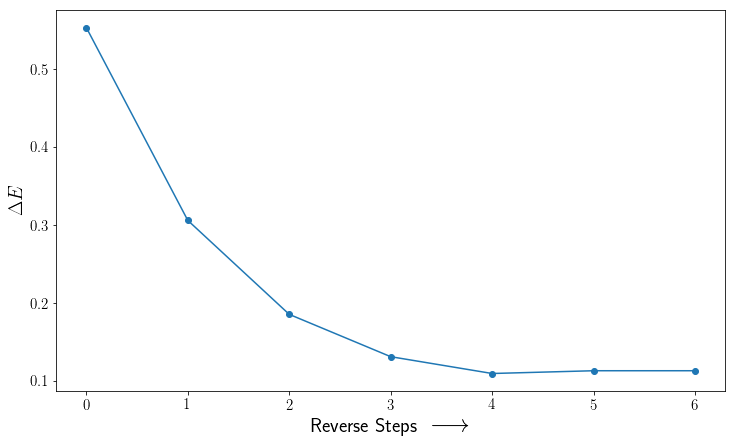

In [75]:
EnergyUncertainity=np.array([0.55328334,0.30568792,0.18498567,0.13063325,0.10903873,0.11259449,0.11259449])
plt.rcParams['figure.figsize'] = [12,7]
plt.plot(EnergyUncertainity,marker='o')
plt.ylabel(r"$\Delta E$",fontsize=20)
plt.rcParams['text.usetex'] = True
plt.xlabel(r'Reverse Steps~~\Huge{$\longrightarrow$}',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)